In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from magicce import entropy, prior_params, find_error_probability, std_eff

In [61]:
# load dataset
expression_df = pd.read_csv('./data/gene_expression.tab', sep='\t', index_col=0)
data = expression_df.values
expression_df.head()

,brain_16mo_rep1,brain_16mo_rep2,brain_16mo_rep3,brain_16mo_rep4,brain_16mo_rep5,brain_2mo_rep1,brain_2mo_rep2,brain_2mo_rep3,brain_2mo_rep4,brain_2mo_rep5,...,muscle_39mo_rep1,muscle_39mo_rep2,muscle_39mo_rep3,muscle_39mo_rep4,muscle_39mo_rep5,muscle_7mo_rep1,muscle_7mo_rep2,muscle_7mo_rep3,muscle_7mo_rep4,muscle_7mo_rep5
GeneID,,,,,,,,,,,,,,,,,,,,,
A2ML1 (1 of many),2.003886,1.699349,1.709527,1.735342,1.719059,1.711328,2.084648,1.953139,2.354774,2.309915,...,1.590810,1.572585,1.677028,2.850064,3.084047,1.930746,8.288445,2.519180,1.637498,1.650748
ABCF3,3.406648,3.367878,3.121997,3.211761,3.580235,3.681889,4.194213,3.889060,3.032369,3.864999,...,6.817735,2.713141,2.042845,3.143494,2.734619,2.525217,4.043733,2.283221,2.963904,2.199464
ACOT12,3.486173,2.841191,3.844378,3.367892,3.649668,3.295562,3.557342,3.184319,4.044197,3.149275,...,3.375806,0.831841,0.281550,0.169860,0.101192,-0.539613,0.888150,-0.490532,-0.405902,-0.173364
ACSF3,0.642943,1.564790,1.291761,1.401428,1.117463,1.140322,1.519899,1.520216,1.514848,-1.025764,...,-0.006755,1.427482,-0.485476,0.733330,-0.325173,0.818976,1.537746,0.385791,-0.031601,-0.706022
ACTC1,-1.025764,-0.290542,-1.025764,-1.025764,-1.025764,-0.808841,-1.025764,-0.902833,-1.025764,-1.025764,...,7.088967,1.757899,1.439672,3.275330,2.601047,2.733269,2.659035,4.052598,5.246153,7.691827


In [3]:
# make DataFrame for column attributes
ca = pd.DataFrame([c.split('_') for c in expression_df.columns], 
                  columns=['tissue', 'age', 'replicate'])
ca.head()

,tissue,age,replicate
0,brain,16mo,rep1
1,brain,16mo,rep2
2,brain,16mo,rep3
3,brain,16mo,rep4
4,brain,16mo,rep5


In [4]:
print(ca.tissue.unique())
print(ca.age.unique())

['brain' 'gill' 'heart' 'liver' 'muscle']
['16mo' '2mo' '39mo' '7mo']


In [5]:
ca.groupby(['tissue', 'age']).count()

replicate
tissue age            
brain  16mo          5
       2mo           5
       39mo          5
       7mo           5
gill   16mo          5
       2mo           5
       39mo          5
       7mo           5
heart  16mo          5
       39mo          4
       7mo           5
liver  16mo          5
       2mo           5
       39mo          5
       7mo           5
muscle 16mo          5
       2mo           5
       39mo          5
       7mo           5

In [82]:
ca[ca.tissue=='heart']

,tissue,age,replicate
40,heart,16mo,rep1
41,heart,16mo,rep2
42,heart,16mo,rep3
43,heart,16mo,rep4
44,heart,16mo,rep5
45,heart,39mo,rep1
46,heart,39mo,rep2
47,heart,39mo,rep3
48,heart,39mo,rep4
49,heart,7mo,rep1


# Inferring marker genes

Find marker genes that differentiate heart from muscle

In [43]:
file = '/scicore/home/nimwegen/reldor00/projects/zebrafish/MARA/running_MARA/age_associated_tissues/posterior_mean/expression.tab'
expression_df = pd.read_csv(file, sep='\t', index_col=0)
data = expression_df.values

In [107]:
# define groups that are compared against each other
groups = [np.flatnonzero(ca.tissue=='heart'), np.flatnonzero(ca.tissue=='muscle')]
groups = [[0,1,2,3,4], [5,6,7,8,9]]
groups = [[74,75,76,77,78],[79,80,81,82,83]]
groups = [[40,41,42,43,44],[45,46,47,49]]
# relative a priori size of different groups,
# discounting potential differences in no. of replicates
nc = [1,1]

In [108]:
params = [prior_params(data[group]) for group in groups]
params

[(0.6588643001488221, 0.38160625952724436),
 (2.4233613071196642, 1.3804295046590136)]

In [167]:
# calculate conditional class entropy
# the parameters k, N determine how accurately the integrals are calculated
# one can start with smaller values and see how much of a difference it makes
H_result = entropy(data, groups, ncond=nc, k=6, N=1e2)

In [168]:
# when there are only two classes, we can invert the entropy function
# H=p*log(p) and infer the probability p of misclassification given gene expression a measurement
# The function find_error_probability is an analytical solution valid only for small p 
p_result = find_error_probability(H_result)

In [169]:
# create sorted list of top marker genes
df_result = pd.DataFrame({'H(c|x)':H_result, 'p_e':p_result}, index=expression_df.index)
df_result = df_result.sort_values(by='p_e')
df_result.head(20)

,H(c|x),p_e
GeneID,,
pimr171,-0.051641,-0.006278+0.003936j
or103-3,-0.051641,-0.006278+0.003936j
si:dkeyp-46h3.5,-0.051641,-0.006278+0.003936j
lgals9l5,-0.051641,-0.006278+0.003936j
CR382300.2,-0.051641,-0.006278+0.003936j
or103-4,-0.051641,-0.006278+0.003936j
si:ch211-225k7.5,-0.051640,-0.006278+0.003936j
si:ch73-46n24.1,-0.051640,-0.006278+0.003935j
pax6a,-0.024280,-0.002787+0.001500j


In [170]:
params

[(0.6588643001488221, 0.38160625952724436),
 (2.4233613071196642, 1.3804295046590136)]

In [171]:
gene = 'pimr171'

In [172]:
gp = 0
x = expression_df.loc[gene][groups[gp]]
print(std_eff(x, params[gp][0], params[gp][1]))
print(x.mean())
x

0.34756998094396957
-2.025764487690599


heart_16mo_rep1   -2.025764
heart_16mo_rep2   -2.025764
heart_16mo_rep3   -2.025764
heart_16mo_rep4   -2.025764
heart_16mo_rep5   -2.025764
Name: pimr171, dtype: float64

In [173]:
gp = 1
x = expression_df.loc[gene][groups[gp]]
print(std_eff(x, params[gp][0], params[gp][1]))
print(x.mean())
x

0.5586385595756356
-2.0257644876905982


heart_39mo_rep1   -2.025764
heart_39mo_rep2   -2.025764
heart_39mo_rep3   -2.025764
heart_7mo_rep1    -2.025764
Name: pimr171, dtype: float64

In [174]:
df_result.loc[gene]

H(c|x)   -0.051641+0.000000j
p_e      -0.006278+0.003936j
Name: pimr171, dtype: complex128

In [175]:
g = np.flatnonzero(expression_df.index==gene)[0]

In [200]:
nc=[1,1]
prior_c = np.array(nc)/sum(nc)
all_c = groups
all_alpha = [p[0] for p in params]
all_beta = [p[1] for p in params]

from scipy.special import gamma

P_xgc = []

P_params = []

for c, alphac, betac in zip(all_c, all_alpha, all_beta):
    datac = data[g, c]
    varc = datac.var(axis=-1)
    Nc = len(c)  # size of class c
    Vc = (Nc + 1)*(varc + 2*betac/Nc)
    xc = datac.mean(axis=-1)
    gc = alphac + (Nc - 1)/2
    Zc = gamma(gc) / (np.sqrt(Vc*np.pi) * gamma(gc-0.5))    
    
    P_params.append([Zc, xc, Vc, gc])

    k=6
    xd = np.sqrt(Vc * (-1 + 10**(k/gc)))
    print(xc, xd)

def P_xgc(x, c):
    """P(x|c)"""
    Zc, xc, Vc, gc = P_params[c]
    return Zc * np.power((1 + (x - xc)**2 / Vc), -gc)

def P_x(x):
    """P(x)"""
    res = np.zeros_like(x)
    for c in range(len(all_c)):
        res += P_xgc(x, c)*prior_c[c]
    return res
    
    
# def integrand(xx):
#     Psum = np.sum(prior_c[:, None] *
#                   np.array([P(xx, cc, a, b) for cc, a, b
#                             in zip(all_c, all_alpha, all_beta)]),
#                   axis=0)
#     return - P(xx, c, alphac, betac)*np.log(Psum)

-2.025764487690599 12.82356037392207
-2.0257644876905982 10.644174838288833


In [201]:
N_g = data.shape[0]

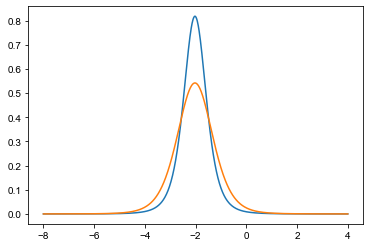

In [202]:
x = np.linspace(-8, 4, 1000)
plt.plot(x, P_xgc(x,0))
plt.plot(x, P_xgc(x,1))

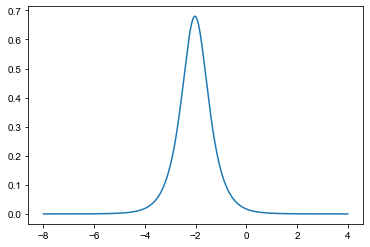

In [203]:
x = np.linspace(-8, 4, 1000)
plt.plot(x, P_x(x))

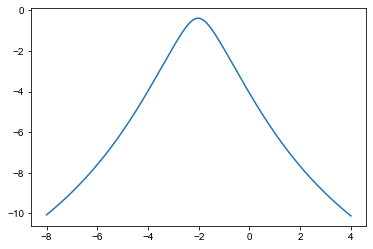

In [204]:
x = np.linspace(-8, 4, 1000)
plt.plot(x, np.log(P_x(x)))

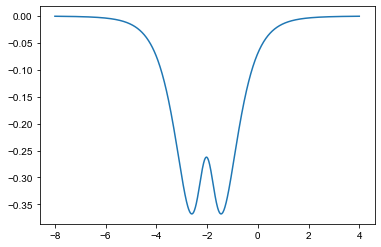

In [205]:
x = np.linspace(-8, 4, 1000)
plt.plot(x, P_x(x)*np.log(P_x(x)))

In [207]:
# Zc, xc, Vc, gc
P_params

[[0.8178818230596822,
  -2.025764487690599,
  0.9158550228653866,
  2.658864300148822],
 [0.5418406474003661,
  -2.0257644876905982,
  3.451073761647534,
  3.9233613071196642]]

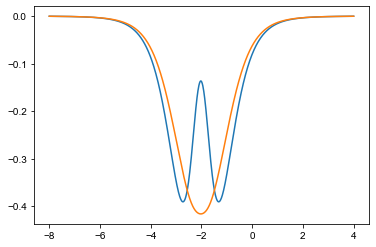

In [206]:
x = np.linspace(-8, 4, 1000)
plt.plot(x, P_x(x)*np.log(P_xgc(x,0)))
plt.plot(x, P_x(x)*np.log(P_xgc(x,1)))

In [208]:
# H(x)
np.sum(P_x(x)*np.log(P_x(x)))*12/1000

-1.0755986085151186

In [209]:
# H(x,c)
prior_c[0]*np.sum(P_xgc(x,0)*np.log(prior_c[0]*P_xgc(x,0)))*12/1000 + \
prior_c[1]*np.sum(P_xgc(x,1)*np.log(prior_c[1]*P_xgc(x,1)))*12/1000

-1.7470381310729837

In [82]:
from scipy.special import gamma, digamma

In [ ]:
params[]

In [90]:
g = np.flatnonzero(df.index==gene)[0]

for c, (alphac, betac) in zip(groups, params):   
    datac = data[g, c]
    nc = len(c)
    varc = datac.var()
    Vc = (nc + 1)*(varc + 2*betac/nc)
#     Vc = np.logspace(-3, 1, num=10)
    gc = alphac + (nc - 1)/2
    Zc = gamma(gc) / (np.sqrt(Vc*np.pi) * gamma(gc-0.5))
    H_xc = -np.log(Zc) + gc*(digamma(gc) - digamma(gc - 0.5))
#     plt.plot(Vc, H_xc)
    print(H_xc, Vc, gc, Zc)
    break

-0.6155487461773373 0.18831248371724862 6.949863983908297 3.2385635170975324


In [93]:
-np.log(Zc)

-1.1751298725710975

In [85]:
np.log(0.5)

-0.6931471805599453

In [80]:
df.loc[gene][groups[1]]

muscle_16mo_rep1   -1.025764
muscle_16mo_rep2   -1.025764
muscle_16mo_rep3   -1.025764
muscle_16mo_rep4   -1.025764
muscle_16mo_rep5   -1.025764
muscle_2mo_rep1    -1.025764
muscle_2mo_rep2    -1.004575
muscle_2mo_rep3    -1.025764
muscle_2mo_rep4    -1.025764
muscle_2mo_rep5    -1.025764
muscle_39mo_rep1   -1.025764
muscle_39mo_rep2   -1.025764
muscle_39mo_rep3   -1.025764
muscle_39mo_rep4   -1.025764
muscle_39mo_rep5   -1.025764
muscle_7mo_rep1    -1.025764
muscle_7mo_rep2    -1.025764
muscle_7mo_rep3    -1.025764
muscle_7mo_rep4    -1.025764
muscle_7mo_rep5    -1.025764
Name: taar19t, dtype: float64

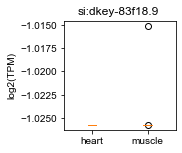

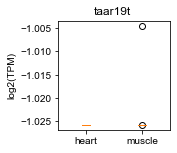

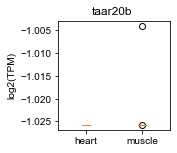

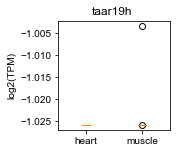

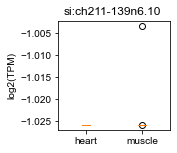

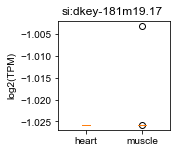

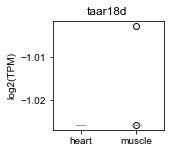

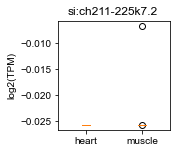

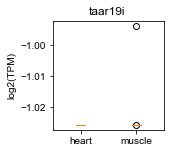

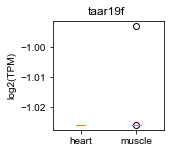

In [77]:
for gene in df_result.index[:10]:
    plot_data = tuple(df.loc[gene][group].values for group in groups)
    plt.figure(figsize=(2,2))
    plt.boxplot(plot_data, labels=['heart', 'muscle'])
    plt.suptitle(gene)
    plt.ylabel('log2(TPM)')
    

In [30]:
import matplotlib.pyplot as plt

(array([1589.,  277.,  350.,  577.,  820., 1264., 2071., 3177., 4903.,
        9301.]),
 array([-3.11561445e-06,  6.92994168e-02,  1.38601949e-01,  2.07904482e-01,
         2.77207014e-01,  3.46509547e-01,  4.15812079e-01,  4.85114611e-01,
         5.54417144e-01,  6.23719676e-01,  6.93022209e-01]),
 <BarContainer object of 10 artists>)

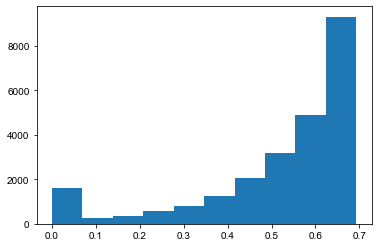

In [31]:
plt.hist(H_result)

```python
# %load example_run.py
import numpy as np
import pandas as pd
from magicce import entropy, find_error_probability

def test():
    # define inverse function of entropy function H = p*log(p)
    # find_error_probability is an approximation for small p
    # alternatively, calculate inverse numerically
    inventropyfunc = find_error_probability

    # import data as a numpy array
    data_file = './data/gene_expression.tab'
    data_df = pd.read_csv(data_file, sep='\t', index_col=0)
    all_data = data_df.values

    # define groups that are compared with each other
    # the chosen indices correspond to 2mo and 16mo brain samples
    groups = [[0,1,2,3,4],[5,6,7,8,9]]

    # find number of different conditions (same cell type/day in groups)
    # prior probabilities that a sample belongs to each group
    # Here, we are comparing one time point against another, so we take [1,1]
    # If we were comparing one time point against 3 others, we would use [1,3]
    nc = [1,1]

    H_result = entropy(all_data, groups, ncond=nc, k=10, N=1E3)
    p_result = inventropyfunc(H_result)

    df = pd.DataFrame({'H(c|x)':H_result, 'p_e':p_result}, index=data_df.index)
    df = df.sort_values(by='p_e')

    # save sorted list of promoter clusters most predictive for different groups
    writefile = './results/testresults.txt'
    df.to_csv(writefile, sep='\t', float_format='%.4e')


if __name__ == "__main__":
    test()
```

In [258]:
# %load magicce/class_entropies.py
"""
For two or more given groups of gene expression samples this script gives an
ordered list of the most promising marker genes that would differentiate between the two
groups.

The scoring is based on the conditional entropy of the classes given the data.
"""
# import relevant python libraries
import numpy as np
from scipy.special import gamma
from scipy.special import digamma
from scipy.special import lambertw
import scipy.integrate as integrate
from magicce import prior_params


def create_ranges(start, stop, N):
    steps = (1.0/(N-1)) * (stop - start)
    return steps[:, None]*np.arange(N) + start[:, None]


def entropy(data, all_c, ncond=None, k=6, N=1E4):
    """ calculates the conditional entropy H(c|x) of multiple genes
    data:   NxM array of N genes across M conditions
    all_c:  list of list of indices indicating which classes the samples are
            split into
    ncond:  number of conditions in each group; gives prior probability
            that a sample is in a group. [default = None, uniform prior]
    k:      parameter setting size of integration domain for H(x)
            [default = 6]
    N:      parameter setting number of bins in integration for H(x)
            [default = 1E4]
    """
    # make sure data are in form of 2D array
    data = np.asarray(data)
    dim = data.ndim
    if dim == 1:
        data = data.reshape(1, -1)
    elif dim == 2:
        pass
    else:
        message = 'dimension of data is {}, but should be 1 or 2'.format(dim)
        raise Exception(message)

    N_g = data.shape[0]  # number of genes

    N_c = len(all_c)  # number of classes

    if ncond is None:
        ncond = np.ones(N_c)
    else:
        ncond = np.asarray(ncond)
    prior_c = ncond/np.sum(ncond)

    # find alpha and beta values
    abparams = [prior_params(data[:, c]) for c in all_c]
    all_alpha = np.array([a[0] for a in abparams])
    all_beta = np.array([a[1] for a in abparams])
    
    # generate summary parameters for P(x|c)
    all_params = []
    for i in range(N_c):
        c = all_c[i]
        alphac = all_alpha[i]
        betac = all_beta[i]
        
        datac = data[:, c]
        varc = datac.var(axis=-1)
        xc = datac.mean(axis=-1)
        nc = len(c)  # size of class c
        Vc = (nc + 1)*(varc + 2*betac/nc)
        gc = alphac + (nc - 1)/2
        Zc = gamma(gc) / (np.sqrt(Vc*np.pi) * gamma(gc-0.5))  
        all_params.append((Zc, xc, Vc, gc))
    
    H_xc = np.zeros(N_g)  # initialize entropy array H(x,c) = H(c) + <H(x|c)>
    for i in range(N_c):      
        Zc, xc, Vc, gc = all_params[i]
        pc = prior_c[i]
        
        # calculate H(x,c)
        H_xc += pc *( -np.log(pc) -np.log(Zc) + gc*(digamma(gc) - digamma(gc - 0.5)) )    
    
    
        
    def P_x(xx):
        """(P(x))"""
        Psum = np.zeros_like(xx)
        for ii in range(N_c):
            Psum += prior_c[ii]*P_xgc(xx, ii)
        return (Psum)
    
    def P_xgc(xx, ii):
        """P(x|c=ii)"""
        Zcc, xcc, Vcc, gcc = all_params[ii]
        res = Zcc[:, None] * \
                np.power((1 + (xx - xcc[:, None])**2 / Vcc[:, None]), -gcc)
        return res
    
    x_low = np.inf*np.ones(N_g)
    x_high = -np.inf*np.ones(N_g)
    for i in range(N_c):
        Zc, xc, Vc, gc = all_params[i]
        xd = np.sqrt(Vc * (-1 + 10**(k/gc)))
        x_low = np.minimum(x_low, xc - xd)
        x_high = np.maximum(x_high, xc + xd)
    
    x = create_ranges(x_low, x_high, N)
    P_vals = P_x(x)
    H_x = -integrate.trapz(P_vals*np.log(P_vals), x, axis=1)
    
    return H_xc, H_x  # /N_c


In [259]:
H_joint, H_marg = entropy(data, groups, ncond=nc, k=6, N=1e3)
np.sort(H_joint-H_marg)

array([-14.62404019, -14.62404019, -14.62404019, ...,   0.69270967,
         0.69271784,   2.38930563])

In [266]:
np.argsort(H_joint-H_marg)[:10]

array([ 8265,  5619, 13327,  3251,  3254, 15632, 17970, 17958, 17957,
       21647])

In [267]:
H_joint[[ 8265,  5619, 13327,  3251,  3254, 15632, 17970, 17958, 17957,
       21647]]

array([-13.99843596, -13.99843596, -13.99843596, -13.99843596,
       -13.99843596, -13.99843596, -13.99843596, -13.99843596,
       -13.99843596, -13.99843596])

In [268]:
H_marg[[ 8265,  5619, 13327,  3251,  3254, 15632, 17970, 17958, 17957,
       21647]]

array([0.62560423, 0.62560423, 0.62560423, 0.62560423, 0.62560423,
       0.62560423, 0.62560423, 0.62560423, 0.62560423, 0.62560423])

In [271]:
data[[ 8265,  5619, 13327,  3251,  3254, 15632, 17970, 17958, 17957,
       21647]][:, groups[0]]

array([[-1.02576449, -1.02576449, -1.02576449, -1.02576449, -1.02576449],
       [-1.02576449, -1.02576449, -1.02576449, -1.02576449, -1.02576449],
       [-1.02576449, -1.02576449, -1.02576449, -1.02576449, -1.02576449],
       [-1.02576449, -1.02576449, -1.02576449, -1.02576449, -1.02576449],
       [-1.02576449, -1.02576449, -1.02576449, -1.02576449, -1.02576449],
       [-1.02576449, -1.02576449, -1.02576449, -1.02576449, -1.02576449],
       [-1.02576449, -1.02576449, -1.02576449, -1.02576449, -1.02576449],
       [-1.02576449, -1.02576449, -1.02576449, -1.02576449, -1.02576449],
       [-1.02576449, -1.02576449, -1.02576449, -1.02576449, -1.02576449],
       [-1.02576449, -1.02576449, -1.02576449, -1.02576449, -1.02576449]])

In [220]:
import magicce

In [248]:
H = magicce.entropy(data, groups, ncond=nc, k=8, N=1e4)
np.sort(H)

array([-2.20898631e-06, -2.20898631e-06, -2.20898631e-06, ...,
        6.92597133e-01,  6.92598508e-01,  6.92598774e-01])

In [ ]:
np.argsort(H)